# Data Querying and Summarising with SQL

This week is about working with an existing database.

The following tutorial assumes a bit of background on SQL, in particular on its core commands 
to create new tables and to retrieve data:

 SQL Command   |  Meaning
 --------------|------------
 SELECT COUNT(\*) FROM *T*   | count how many tuples are stored in table *T*
 SELECT \* FROM *T*          | list the content of table *T*
 SELECT \* FROM *T* LIMIT *n* | only list  *n* tuples from a table
 SELECT \* FROM *T* ORDER BY *a* | order the result by attribute *a* (in ascending order; add DESC for descending order)

You can learn more background on these SQL commands in the [Ed lessons on SQL] (Module 16 onwards).


### SQL: Joins

If you need to combine data from multiple tables, you can **join** those as follows.

**Example:** We would like to find out the details on when and where the temperature values were recorded.

We first can have a look at the <tt>Measurement</tt> table:
<pre>
SELECT station, value, date
  FROM Measurement
 WHERE sensor = 'temp'; 
</pre>

If you execute the SQL query above, you see that the temperature was measured at two different stations over the course of two years. But we cannot see the station  details directly, just an internal ID that refers to the <tt>Station</tt> table.

You could now look into that table too with a second query and check for the two different stations mentioned above - but that is tedious and error prone...
<pre>
SELECT * FROM Station;
</pre>

The correct way is to use the *foreign key* attribute <tt>station</tt> from the <tt>Measurment</tt> table to **join** both the <tt>Measurment</tt> and the <tt>station</tt> tables and retreive the macthing values in just one query:

<pre>
SELECT  value, date, SiteName
  FROM Measurement JOIN station USING (station)
  WHERE sensor = 'temp';
</pre>


### Working with DATE values 

For most data types in SQL - notably integers, strings, floating point numbers - the standard comparison and numerical operations apply.

The handling of <tt>DATE</tt> is a bit delicate though. You can compare them using date strings, but the standard date format can be configured differently in database systems than you expect (eg. 'yyyy-mm-dd' vs. 'dd/mm/yyyy' etc), so that these kind of codes are difficult to port.

<pre>
SELECT *
  FROM Measurement
 WHERE date = '2005-04-29';
</pre>

<pre>
SELECT *
  FROM Measurement
 WHERE date = '29/04/2005'; 
</pre>

The SQL **EXTRACT()** function provides a convenient way to access any part of a date value. For example, **extract(year from datevar)** allows to extract the year component of a given date cariable *datevar*.
For a full description of all components available to *extract()*, see [the PostgreSQL online documentation][1].

**Example:**
<pre>
SELECT *
  FROM Measurement
 WHERE extract(year from date) = 2004;
</pre>

 [1]:[http://www.postgresql.org/docs/current/static/functions-datetime.html#FUNCTIONS-DATETIME-EXTRACT]

### SQL: Aggregation Functions

SQL supports multiple aggregation functions.

 SQL Aggregate Function | Meaning
 --- | ---
 COUNT(\*)   | count all tuples in a table
 COUNT(attr) | count the tuples with a non-NULL value in attr
 MIN(attr)   | determine the minimum value of attr (ignores NULL)
 MAX(attr)   | determine the maximum value of attr (ignores NULL)
 AVG(attr)   | determine the average value of numeric attr (arithmetic mean) (ignores NULL)
 SUM(attr)   | calculates the sum of a numeric attr (ignores NULL)



Try some out:


**Question:** In which range (i.e., minimum to maximum) did the temp sensor do the measurements?
<pre>
SELECT MIN(value), MAX(value) FROM Measurement WHERE sensor = 'temp';  
</pre>



### SQL Statistical Aggregates

SQL also supports some statistical aggregates. The syntax is a bit more complex, as they work on ordered sets. This order has to be first specified with a *WITHIN GROUP* clause in SQL so that aggregates like 'Median' or 'Percentile' make sense.

Statistics Aggregate | Meaning
---|---
MODE()  WITHIN GROUP (ORDER BY *attr*) |  mode function over *attr*
PERCENTILE_DISC(0.5) WITHIN GROUP (ORDER BY *attr*) | median of the *attr* values
PERCENTILE_DISC(*p*) WITHIN GROUP (ORDER BY *attr*) | *p* percentile of the *attr* values

**Example:** Statistical analysis over the temperature values of *all* measurements.

<pre>
SELECT COUNT(value),
       MIN(value),
       Max(value), 
       MAX(value) - MIN(value)                               AS Range, 
       AVG(value)                                            AS Mean,
       MODE()  WITHIN GROUP (ORDER BY value)                 AS Mode, 
       PERCENTILE_DISC(0.5) WITHIN GROUP (ORDER BY value)    AS Median,
       PERCENTILE_DISC(0.25) WITHIN GROUP (ORDER BY value)   AS Percentile25, 
       PERCENTILE_DISC(0.75) WITHIN GROUP (ORDER BY value)   AS Percentile75,
       PERCENTILE_DISC(0.75) WITHIN GROUP (ORDER BY value)
       - PERCENTILE_DISC(0.25) WITHIN GROUP (ORDER BY value) AS IQR 
  FROM Measurement WHERE sensor='temp';
</pre>

## EXERCISE 1: Data Gathering from an SQL Database

In this next exercise, we will be looking into how to retrieve data from an existing SQL database into a Python program for further analysis.

##  Data Loading and Exploring for Water Database

### Step1: Loading Water DB

The first step is to make sure that the water data set is fully loaded into our PostgreSQL database (week 4 tutorial completed).

### Step 2: DB Connection and Query Execution

In the first step, we are repeating the basic database connection phase from the tutorial in Week 4 and we execute a simple SQL query on that database.



In [1]:
import psycopg2
import psycopg2.extras

def pgconnect():
    # please replace with your own details
    YOUR_DBNAME = 'postgres'    
    YOUR_USERNAME = 'postgres'
    YOUR_PW     = ''
    try: 
        conn = psycopg2.connect(host='localhost',
                                database=YOUR_DBNAME,
                                user=YOUR_USERNAME, 
                                password=YOUR_PW)
        print('connected')
    except Exception as e:
        print("unable to connect to the database")
        print(e)
    return conn

#returntype: This parameter is optional and defaults to 'tuple'. It specifies type of return value desired ('tuple' or 'dict').
def pgquery( conn, sqlcmd, args, silent=False, returntype='tuple'):
   """ utility function to execute some SQL query statement
       it can take optional arguments (as a dictionary) to fill in for placeholder in the SQL
       will return the complete query result as return value - or in case of error: None
       error and transaction handling built-in (by using the 'with' clauses) """
   retval = None
   with conn:
#If returntype is 'dict', it uses RealDictCursor, which returns rows as dictionaries.
      cursortype = None if returntype != 'dict' else psycopg2.extras.RealDictCursor     
      with conn.cursor(cursor_factory=cursortype) as cur:
         try:
            if args is None:
                cur.execute(sqlcmd)
            else:
                cur.execute(sqlcmd, args)
            retval = cur.fetchall() # we use fetchall() as we expect only _small_ query results
         except Exception as e:
            if e.pgcode != None and not(silent):
                print("db read error: ")
                print(e)
   return retval

In [2]:
import pprint
# connect to your database
conn = pgconnect()
    
# prepare SQL statement
query_stmt = "SELECT * FROM Sensor"

# execute query and print result
query_result = pgquery (conn, query_stmt, None)
print(query_stmt)
pprint.pprint(query_result)

# prepare another SQL statement including placeholders
query_stmt = "SELECT * FROM Measurement WHERE date=%(date)s limit 3"

# define the 'date' parameter, execute query+parameters, and print result
param = {'date' : '2005-04-29'}
query_result = pgquery (conn, query_stmt, param)
print(query_stmt)
pprint.pprint(query_result)

# cleanup
conn.close()

connected
SELECT * FROM Sensor
[('levl', 'Level - Stream Water (Gauge Height)', 'meter'),
 ('temp', 'Water Temperature', 'celsius'),
 ('disc', 'Discharge Rate', 'ML/d'),
 ('disvol', 'Discharge Volume', 'ML'),
 ('ph', 'pH Value', 'pH'),
 ('ec25', 'Electrical Conductivity @25 C', 'us/cm'),
 ('ec', 'Electrical Conductivity (uncorrected)', 'us/cm')]
SELECT * FROM Measurement WHERE date=%(date)s limit 3
[('409204C', 'levl', datetime.date(2005, 4, 29), 0.692),
 ('409204C', 'disvol', datetime.date(2005, 4, 29), 2689.099),
 ('409204C', 'disc', datetime.date(2005, 4, 29), 2724.934)]


## YOUR TASK:

Run the above SQL examples and then answer the following questions with an SQL query:

1.  In which time period were all the measurement done?

2.  At how many distinct Stations were used? Which Stations?

3.  Do the same statistical analysis for temprature measurements as (2) above, but just for measurements from the year 2005;


In [3]:
# TODO: replace the content of this cell with your SQL solution

conn = pgconnect()

#1 In which time period were all the measurement done?
query_stmt = "SELECT min(date), max(date) FROM Measurement;"
query_result = pgquery (conn, query_stmt, None)
print("Q1:", query_result)

#2 At how many distinct Stations were used? Which Stations?
query_stmt2 = "SELECT COUNT(DISTINCT station) FROM Measurement;"
query_result2 = pgquery (conn, query_stmt2, None)
print("Q2_1:", query_result2)

query_stmt2 = """SELECT DISTINCT station, sitename 
FROM Measurement NATURAL JOIN Station;"""
query_result2 = pgquery (conn, query_stmt2, None)
print("Q2_2:", query_result2)

#3 Do the same statistical analysis for temprature measurements as above, but for just measurements from the year 2005
query_stmt3 = """SELECT DISTINCT station, sitename 
FROM Measurement NATURAL JOIN Station
WHERE extract(year FROM date) = 2005 and 
sensor = 'temp';"""
query_result3 = pgquery (conn, query_stmt3, None)
print("Q3:", query_result3)
conn.close()

connected
Q1: [(datetime.date(2004, 12, 31), datetime.date(2005, 5, 22))]
Q2_1: [(3,)]
Q2_2: [('219018', 'Murray River @ Quaama'), ('409017', 'Murray River @ Doctors Point'), ('409204C', 'Murray River @ Swan Hill')]
Q3: [('409017', 'Murray River @ Doctors Point'), ('409204C', 'Murray River @ Swan Hill')]


# STOP PLEASE. THE FOLLOWING IS FOR THE NEXT EXERCISE. THANKS.

## EXERCISE 2: Summarising Data with SQL

In the next exercise, we look at the SQL language in a bit more depth.

#### SQL: Data Analysis with GROUP BY

So far, our aggregate functions were always applied to all tuples in a table.
Sometimes it is however very useful to group  rows into distinct partitions and then aggregate for each partition separatly. This is what the **GROUP BY** clause of SQL is doing.

**Example 1:**
How many measurements were done *per each sensor*?
<pre>
  SELECT sensor, COUNT(*)
    FROM Measurement
   GROUP BY sensor;
</pre>

**Example 2:**
How many measurements of *distinct* stations were done *per each sensor*?
<pre>
SELECT sensor, COUNT(DISTINCT station)
  FROM Measurement
 GROUP BY sensor
 ORDER BY count DESC;
</pre>
<pre>
SELECT station, sensor, COUNT(*)
  FROM Measurement 
 GROUP BY station, sensor
 ORDER BY count DESC;
</pre>

**Example 3:**
Determine some basic statistics about the measured temperature values *per each station*, including minimum temperature, maximum temperature, range of temperature values, mean, mode, 25th and 75th percentile:
<pre>
SELECT siteName,
       MIN(value), 
       Max(value), 
       MAX(value) - MIN(value)                               AS Range,
       AVG(value)                                            AS Mean,
       MODE()  WITHIN GROUP (ORDER BY value)                 AS Mode, 
       PERCENTILE_DISC(0.5) WITHIN GROUP (ORDER BY value)    AS Median,
       PERCENTILE_DISC(0.25) WITHIN GROUP (ORDER BY value)   AS Percentile25,
       PERCENTILE_DISC(0.75) WITHIN GROUP (ORDER BY value)   AS Percentile75,
       PERCENTILE_DISC(0.75) WITHIN GROUP (ORDER BY value)
       - PERCENTILE_DISC(0.25) WITHIN GROUP (ORDER BY value) AS IQR 
  FROM Measurement NATURAL JOIN Station
  WHERE sensor ='temp'
 GROUP BY siteName;
</pre>

#### YOUR TASK:

Answer the following questions with SQL GROUP-BY queries:

1. Determine the same per-station statistics as in the last grouping query just for measurements in 2005.

2. Same as in (1), but just those values with at least 142 measurements.

3. How many Measurement were done in 2004 per sensor?

4. In which station were the most measurements done?

5. Which sensors were used multiple times in different stations?


In [ ]:
# TODO: replace the content of this cell with your SQL solution

import pprint

conn = pgconnect();

#1 Determine the same per-station statistics as in the last grouping query just for measurements in 2005
query_stmt = """
SELECT siteName,
       MIN(value), 
       MAX(value), 
       MAX(value) - MIN(value)                               AS Range,
       AVG(value)                                            AS Mean,
       MODE()  WITHIN GROUP (ORDER BY value)                 AS Mode, 
       PERCENTILE_DISC(0.5) WITHIN GROUP (ORDER BY value)    AS Median,
       PERCENTILE_DISC(0.25) WITHIN GROUP (ORDER BY value)   AS Percentile25,
       PERCENTILE_DISC(0.75) WITHIN GROUP (ORDER BY value)   AS Percentile75,
       PERCENTILE_DISC(0.75) WITHIN GROUP (ORDER BY value)
       - PERCENTILE_DISC(0.25) WITHIN GROUP (ORDER BY value) AS IQR 
FROM Measurement NATURAL JOIN Station
WHERE sensor ='temp' AND extract(year from date) = 2005
GROUP BY siteName;
"""
query_result = pgquery (conn, query_stmt, None)
print("Q1:", query_result)

#2 Same as in (1), but just those values with at least 142 measurements.
query_stmt2 = """
SELECT siteName,
       MIN(value), 
       MAX(value), 
       MAX(value) - MIN(value)                               AS Range,
       AVG(value)                                            AS Mean,
       MODE()  WITHIN GROUP (ORDER BY value)                 AS Mode, 
       PERCENTILE_DISC(0.5) WITHIN GROUP (ORDER BY value)    AS Median,
       PERCENTILE_DISC(0.25) WITHIN GROUP (ORDER BY value)   AS Percentile25,
       PERCENTILE_DISC(0.75) WITHIN GROUP (ORDER BY value)   AS Percentile75,
       PERCENTILE_DISC(0.75) WITHIN GROUP (ORDER BY value)
       - PERCENTILE_DISC(0.25) WITHIN GROUP (ORDER BY value) AS IQR 
  FROM Measurement NATURAL JOIN Station
  WHERE sensor ='temp' AND extract(year from date) = 2005
 GROUP BY siteName
 HAVING COUNT(*) >= 142;
"""
query_result2 = pgquery (conn, query_stmt2, None)
print("Q2:", query_result2)

#3 How many Measurement were done in 2004 per sensor?
query_stmt3 = """
SELECT sensor, count(*)
FROM measurement 
WHERE extract(year from date) = 2004
GROUP BY sensor
"""
query_result3 = pgquery (conn, query_stmt3, None)
print("Q3:", query_result3)

#4 In which station were the most measurements done?
query_stmt4 = """
SELECT station
FROM Measurement
GROUP BY station
HAVING COUNT(*) >= ALL(SELECT count(*) FROM Measurement GROUP BY station)
;
"""
query_result4 = pgquery (conn, query_stmt4, None)
print("Q4:", query_result4)

#5 Which sensors were used multiple times in different stations?
query_stmt5 = """
SELECT sensor, count(distinct station)
FROM Measurement
GROUP BY sensor
HAVING count(distinct station) > 1
"""
query_result5 = pgquery (conn, query_stmt5, None)
print("Q5:", query_result5)

conn.close()

connected
Q1: [('Murray River @ Doctors Point', 10.983, 26.292, 15.309000000000001, 20.212864285714286, 23.4, 21.505, 17.152, 23.31, 6.157999999999998), ('Murray River @ Swan Hill', 13.757, 29.805, 16.048000000000002, 21.409816901408455, 13.757, 22.074, 17.867, 24.424, 6.556999999999999)]
Q2: [('Murray River @ Swan Hill', 13.757, 29.805, 16.048000000000002, 21.409816901408455, 13.757, 22.074, 17.867, 24.424, 6.556999999999999)]
Q3: [('disc', 3), ('disvol', 3), ('ec', 2), ('levl', 3), ('temp', 2)]
Q4: [('409204C',)]
Q5: [('disc', 3), ('disvol', 3), ('ec', 2), ('levl', 3), ('temp', 2)]


# STOP PLEASE. THE FOLLOWING IS FOR THE NEXT EXERCISE. THANKS.

## Gathering Data for Visualization

Of course you do not need to just print the result of a database operation directly to the screen. Once it is in a variable in your Python program, you can work with it as with any other data which you have loaded, eg. from a CSV file before.

**Note** that the data read from the postgresql database differs in its typing from the data we retrieved from CSV files so far using the CSV.DictReader:
 - SQL returns by default a **list of tuples**, while the data read with the CSV reader is a **list of dictionaries**.
 - The attributes in the tuples of the SQL result are **typed** according to the SQL schema, while the CSV data is **always strings** and hence needs to be type-converted first.
 
The differences is the addressability of each component - in one case positionally, in the other as key-value pairs, and whether we need further type conversions from strings to numbers, or not. 

The following code snippet demonstrates these typing differences.

In [5]:
# here the type and content analysed for the SQL query result from above
print("Analysis of the SQL result types - first whole result, then just first entry:")
print( type(query_result) )
print( query_result )
print( type(query_result[0]) )
print( query_result[0] )
print( type(query_result[0][0]) )
print( query_result[0][0] )

# and now for comaprison the type and values read from the raw CSV file
import csv
data_measurements = list(csv.DictReader(open('Sensors.csv')))

print("\nAnalysis of the CSV result types - first whole result, then just first entry:")
print( type(data_measurements) )
print( data_measurements)
print( type(data_measurements[0]) )
print( data_measurements[0])
print( type(data_measurements[0]['metric']) )
print( data_measurements[0]['metric']) # we need to know the attribute key
# print( data_measurements[0][0]) # does not work!

Analysis of the SQL result types - first whole result, then just first entry:
<class 'list'>
[('Murray River @ Doctors Point', 10.983, 26.292, 15.309000000000001, 20.212864285714286, 23.4, 21.505, 17.152, 23.31, 6.157999999999998), ('Murray River @ Swan Hill', 13.757, 29.805, 16.048000000000002, 21.409816901408455, 13.757, 22.074, 17.867, 24.424, 6.556999999999999)]
<class 'tuple'>
('Murray River @ Doctors Point', 10.983, 26.292, 15.309000000000001, 20.212864285714286, 23.4, 21.505, 17.152, 23.31, 6.157999999999998)
<class 'str'>
Murray River @ Doctors Point

Analysis of the CSV result types - first whole result, then just first entry:
<class 'list'>
[{'sensor': 'levl', 'description': 'Level - Stream Water (Gauge Height)', 'metric': 'meter'}, {'sensor': 'temp', 'description': 'Water Temperature', 'metric': 'celsius'}, {'sensor': 'disc', 'description': 'Discharge Rate', 'metric': 'ML/d'}, {'sensor': 'disvol', 'description': 'Discharge Volume', 'metric': 'ML'}, {'sensor': 'ph', 'descript

You can read data from a database also into a dictionary, where the keys of each value will be the attribute names from the database schema. This needs a special kind of SQL cursor, a so-called dictionary cursor, which uses the attribute names from the database schema as column keys. The previusly introduced *pgquery()* function allows to pass a 'returntype' argument with which we can control its return type. It controls just a small code variation in how the query cursor is opened. If you set this parameter value to 'dict', we will get the query result as a Python dictionary (dict) returned.

In [6]:
# connect to your database
conn = pgconnect()
    
# prepare SQL statement
query_stmt ="""SELECT sensor, COUNT(*)
                 FROM Measurement
             GROUP BY sensor;"""
# execute query and print result
query_result = pgquery (conn, query_stmt, None, returntype='dict')
print(query_result)
for r in query_result:
    print(r)

# cleanup
conn.close()

connected
[RealDictRow([('sensor', 'disc'), ('count', 413)]), RealDictRow([('sensor', 'ec'), ('count', 284)]), RealDictRow([('sensor', 'temp'), ('count', 284)]), RealDictRow([('sensor', 'levl'), ('count', 406)]), RealDictRow([('sensor', 'disvol'), ('count', 406)])]
RealDictRow([('sensor', 'disc'), ('count', 413)])
RealDictRow([('sensor', 'ec'), ('count', 284)])
RealDictRow([('sensor', 'temp'), ('count', 284)])
RealDictRow([('sensor', 'levl'), ('count', 406)])
RealDictRow([('sensor', 'disvol'), ('count', 406)])



## EXERCISE 3:  Data Visualisation of Query Results

Next we want to do some data visualisation with data read from a SQL database.

The **make_plot()** function below will take any query result and turn it into either a simple bar chart, or a scatter plot. Which one you can control with the last 'categorica' argument which schould be True for a bar chart, otherwise false.

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def make_plot(data, x_key, y_key, title, xlabel=None, ylabel=None, bar_width=0.5, categorical=True):
    xlabel = xlabel or x_key
    ylabel = ylabel or y_key
    xs = [row[x_key] for row in data]
    ys = [row[y_key] for row in data]
    
    if categorical:
        plt.bar(range(len(data)), ys, width=bar_width)
        plt.xticks(np.arange(len(data)), xs)
    else:
        plt.scatter(xs, ys)

    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()

Let's now use this function to plot our previous query result in first a bar chart, and then a scatter plot of the 'sensor' value versus the 'count' .

connected
RealDictRow([('sensor', 'disc'), ('count', 413)])
RealDictRow([('sensor', 'ec'), ('count', 284)])
RealDictRow([('sensor', 'temp'), ('count', 284)])
RealDictRow([('sensor', 'levl'), ('count', 406)])
RealDictRow([('sensor', 'disvol'), ('count', 406)])


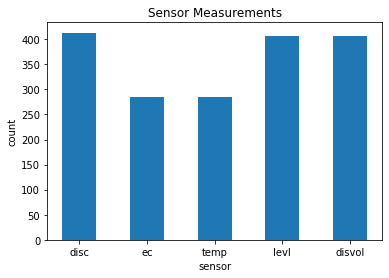

In [8]:
# connect to your database
conn = pgconnect()
    
# prepare SQL statement
query_stmt ="""SELECT sensor, COUNT(*)
                 FROM Measurement
             GROUP BY sensor;"""
# execute query and print result
query_result = pgquery (conn, query_stmt, None, returntype='dict')
# print(query_result)
for r in query_result:
    print(r)

# cleanup
conn.close()

make_plot(
    query_result,
    x_key='sensor',
    y_key='count',
    title='Sensor Measurements',
    categorical=True)

connected
[RealDictRow([('station', '409017'), ('sensor', 'temp'), ('date', datetime.date(2005, 5, 22)), ('value', 11.585)]), RealDictRow([('station', '409204C'), ('sensor', 'temp'), ('date', datetime.date(2005, 5, 22)), ('value', 13.95)]), RealDictRow([('station', '409017'), ('sensor', 'temp'), ('date', datetime.date(2005, 5, 21)), ('value', 11.583)]), RealDictRow([('station', '409204C'), ('sensor', 'temp'), ('date', datetime.date(2005, 5, 21)), ('value', 14.04)]), RealDictRow([('station', '409204C'), ('sensor', 'temp'), ('date', datetime.date(2005, 5, 20)), ('value', 14.058)]), RealDictRow([('station', '409017'), ('sensor', 'temp'), ('date', datetime.date(2005, 5, 20)), ('value', 11.454)]), RealDictRow([('station', '409017'), ('sensor', 'temp'), ('date', datetime.date(2005, 5, 19)), ('value', 10.983)]), RealDictRow([('station', '409204C'), ('sensor', 'temp'), ('date', datetime.date(2005, 5, 19)), ('value', 13.85)]), RealDictRow([('station', '409017'), ('sensor', 'temp'), ('date', dat

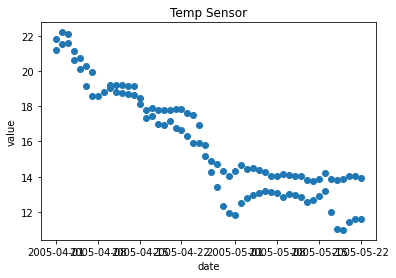

In [9]:
# connect to your database
conn = pgconnect()
    
# prepare SQL statement
query_stmt ="""SELECT *
                 FROM Measurement
                WHERE sensor = 'temp' AND extract(month from date) BETWEEN 4 AND 5 ORDER BY date DESC"""
# execute query and print result
query_result = pgquery (conn, query_stmt, None, returntype='dict')
print(query_result)

# cleanup
conn.close()

make_plot(
    query_result,
    x_key='date',
    y_key='value',
    title='Temp Sensor',
    categorical=False)

Note: The code above assumes that you have the query_result from the previous query in a *dict()* type. However the **make_plot()** function would work with a list of tuples too. In this case, simply provide the positional values of the x- and y-attributes for *x_key* and *y_key* (like for example 0 and 1).

## YOUR TASK:

Next visualise something more interesting, for example visualise the result of the following SQL query:
<pre>
SELECT sensor, COUNT(DISTINCT station)
  FROM Measurement
 GROUP BY sensor
 ORDER BY count DESC;
</pre>

Try out some other code examples from Week 3 that visualises the data read from the SQL database. 

connected
RealDictRow([('sensor', 'disc'), ('count', 3)])
RealDictRow([('sensor', 'disvol'), ('count', 3)])
RealDictRow([('sensor', 'levl'), ('count', 3)])
RealDictRow([('sensor', 'ec'), ('count', 2)])
RealDictRow([('sensor', 'temp'), ('count', 2)])


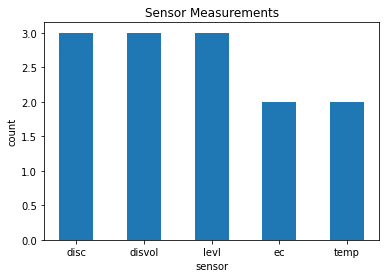

In [10]:
# TODO: replace the content of this cell with your Pythoin+SQL solution
# raise NotImplementedError

# connect to your database
conn = pgconnect()

# prepare SQL statement
query_stmt ="""
SELECT sensor, COUNT(DISTINCT station)
  FROM Measurement
 GROUP BY sensor
 ORDER BY count DESC;
"""
# execute query and print result
query_result = pgquery (conn, query_stmt, None, returntype='dict')
# print(query_result)
for r in query_result:
    print(r)

# cleanup
conn.close()

make_plot(
    query_result,
    x_key='sensor',
    y_key='count',
    title='Sensor Measurements',
    categorical=True)

# That's it for today. THANKS.